In [1]:
import numpy as np
import pandas as pd
import os
import gc

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder

from scipy.optimize import minimize
import xgboost as xgb
from xgboost import XGBClassifier
import lightgbm as lgb
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier, Pool


import warnings
warnings.simplefilter('ignore')

In [2]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/playground-series-s5e11/sample_submission.csv
/kaggle/input/playground-series-s5e11/train.csv
/kaggle/input/playground-series-s5e11/test.csv


In [3]:
base_dir = '/kaggle/input/playground-series-s5e11/'

In [4]:
df_train = pd.read_csv(f'{base_dir}train.csv')
df_test = pd.read_csv(f'{base_dir}test.csv')
df_sub = pd.read_csv(f'{base_dir}sample_submission.csv')

In [5]:
df_train.head()

,id,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,gender,marital_status,education_level,employment_status,loan_purpose,grade_subgrade,loan_paid_back
0,0,29367.99,0.084,736,2528.42,13.67,Female,Single,High School,Self-employed,Other,C3,1.0
1,1,22108.02,0.166,636,4593.10,12.92,Male,Married,Master's,Employed,Debt consolidation,D3,0.0
2,2,49566.20,0.097,694,17005.15,9.76,Male,Single,High School,Employed,Debt consolidation,C5,1.0
3,3,46858.25,0.065,533,4682.48,16.10,Female,Single,High School,Employed,Debt consolidation,F1,1.0
4,4,25496.70,0.053,665,12184.43,10.21,Male,Married,High School,Employed,Other,D1,1.0


In [6]:
print('Train Shape',df_train.shape)
print('Test Shape',df_test.shape)

Train Shape (593994, 13)
Test Shape (254569, 12)


In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 593994 entries, 0 to 593993
Data columns (total 13 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    593994 non-null  int64  
 1   annual_income         593994 non-null  float64
 2   debt_to_income_ratio  593994 non-null  float64
 3   credit_score          593994 non-null  int64  
 4   loan_amount           593994 non-null  float64
 5   interest_rate         593994 non-null  float64
 6   gender                593994 non-null  object 
 7   marital_status        593994 non-null  object 
 8   education_level       593994 non-null  object 
 9   employment_status     593994 non-null  object 
 10  loan_purpose          593994 non-null  object 
 11  grade_subgrade        593994 non-null  object 
 12  loan_paid_back        593994 non-null  float64
dtypes: float64(5), int64(2), object(6)
memory usage: 58.9+ MB


In [8]:
df_train.isna().sum()

id                      0
annual_income           0
debt_to_income_ratio    0
credit_score            0
loan_amount             0
interest_rate           0
gender                  0
marital_status          0
education_level         0
employment_status       0
loan_purpose            0
grade_subgrade          0
loan_paid_back          0
dtype: int64

In [9]:
df_test.isna().sum()

id                      0
annual_income           0
debt_to_income_ratio    0
credit_score            0
loan_amount             0
interest_rate           0
gender                  0
marital_status          0
education_level         0
employment_status       0
loan_purpose            0
grade_subgrade          0
dtype: int64

In [10]:
def disp_ax(ax):
    totals = []
    for container in ax.containers:
        total = 0
        for bar in container:
            total += bar.get_height()
        totals.append(total)
    
    # Add value labels as percentages inside the bar
    for i, container in enumerate(ax.containers):
        for j, bar in enumerate(container):
            ax.annotate(str(round(bar.get_height()/totals[i]*100, 2)) + '%', 
                        xy=(bar.get_x() + bar.get_width() / 2, bar.get_height()),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')
    
    # Show the plot
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right') 
    plt.show()

In [11]:
object_columns = df_train.select_dtypes(include=['object']).columns.tolist()
object_columns

['gender',
 'marital_status',
 'education_level',
 'employment_status',
 'loan_purpose',
 'grade_subgrade']

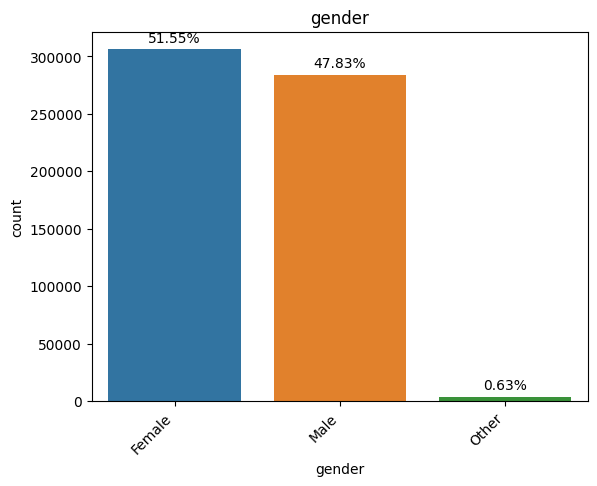

In [12]:
ax = sns.countplot(x=object_columns[0], data=df_train,)
ax.set_title(f"{object_columns[0]}")
disp_ax(ax)

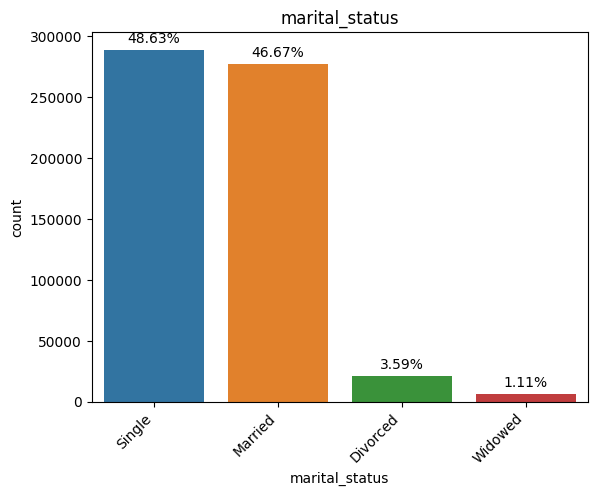

In [13]:
ax = sns.countplot(x=object_columns[1], data=df_train,)
ax.set_title(f"{object_columns[1]}")
disp_ax(ax)

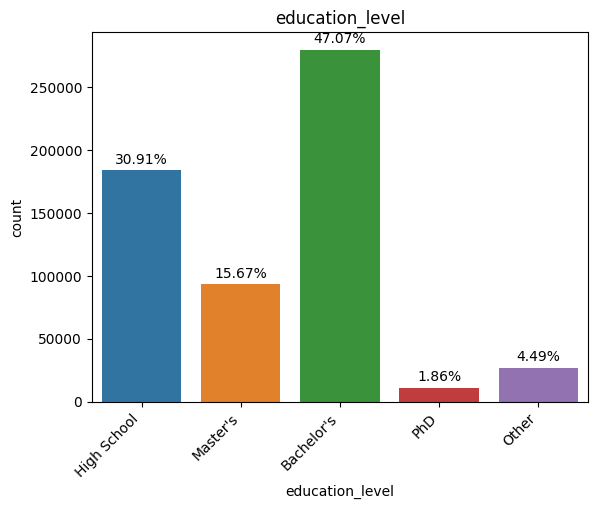

In [14]:
ax = sns.countplot(x=object_columns[2], data=df_train,)
ax.set_title(f"{object_columns[2]}")
disp_ax(ax)

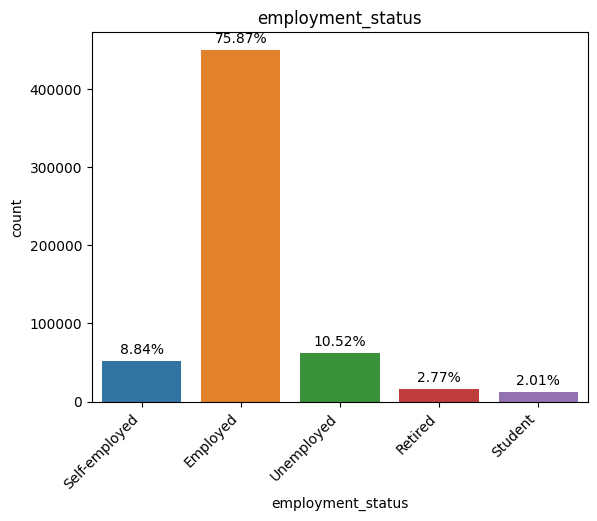

In [15]:
ax = sns.countplot(x=object_columns[3], data=df_train,)
ax.set_title(f"{object_columns[3]}")
disp_ax(ax)

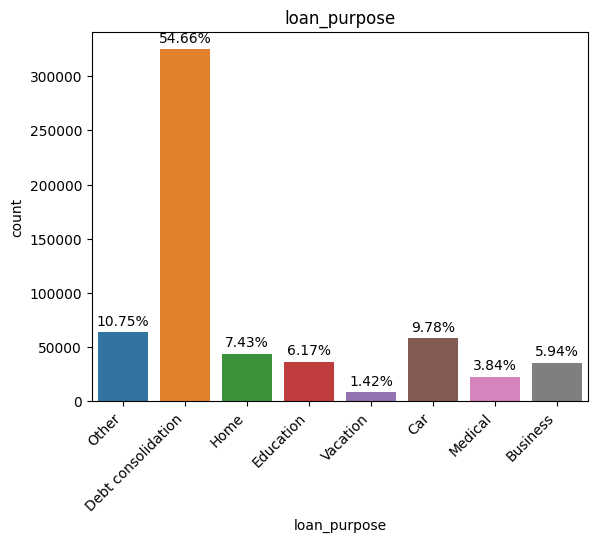

In [16]:
ax = sns.countplot(x=object_columns[4], data=df_train,)
ax.set_title(f"{object_columns[4]}")
disp_ax(ax)
# ha='right' for better alignment with rotation


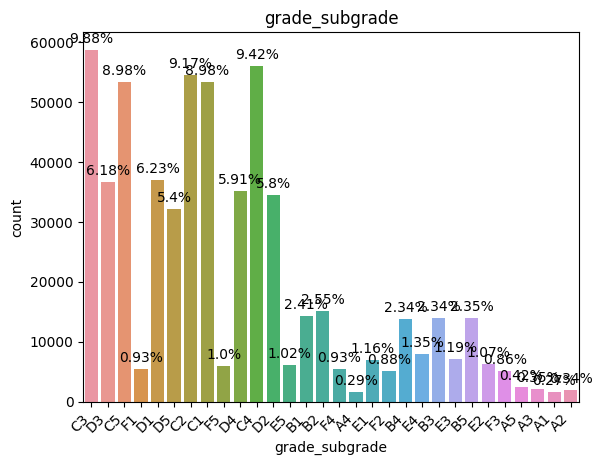

In [17]:
ax = sns.countplot(x=object_columns[5], data=df_train,)
ax.set_title(f"{object_columns[5]}")
disp_ax(ax)

In [18]:
def create_grade_subgrade_column(df):
    df[['grade', 'subgrade']] = df['grade_subgrade'].str.extract(r'([A-Za-z]+)(\d+)')
    df['subgrade'] = df['subgrade'].astype(int)

    return df

In [19]:
df_train = create_grade_subgrade_column(df_train)
df_test = create_grade_subgrade_column(df_test)

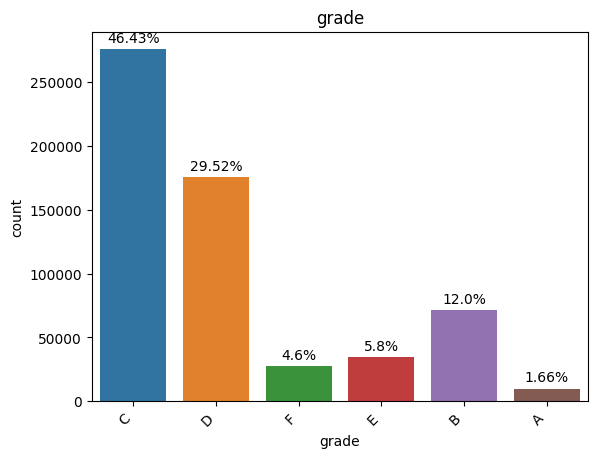

In [20]:
ax = sns.countplot(x='grade', data=df_train,)
ax.set_title(f"{'grade'}")
disp_ax(ax)

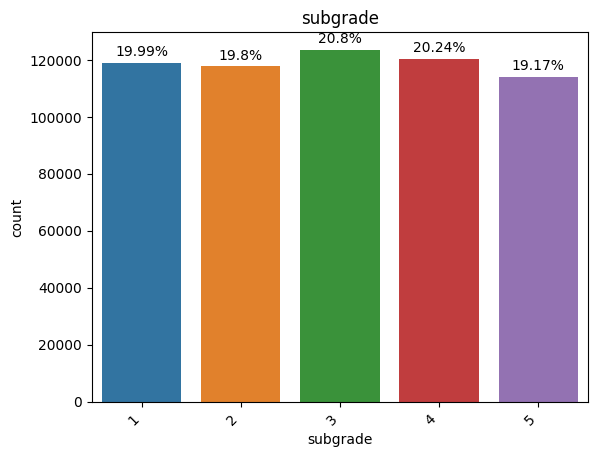

In [21]:
ax = sns.countplot(x='subgrade', data=df_train,)
ax.set_title(f"{'subgrade'}")
disp_ax(ax)

In [22]:
categorical_cols = df_train.select_dtypes(include=['object', 'category']).columns.tolist()
numeric_cols = df_train.select_dtypes(include=['number']).columns.tolist()

print(f"categorical_cols: {categorical_cols}")
print(f"\nnumeric_cols: {numeric_cols}")

categorical_cols: ['gender', 'marital_status', 'education_level', 'employment_status', 'loan_purpose', 'grade_subgrade', 'grade']

numeric_cols: ['id', 'annual_income', 'debt_to_income_ratio', 'credit_score', 'loan_amount', 'interest_rate', 'loan_paid_back', 'subgrade']


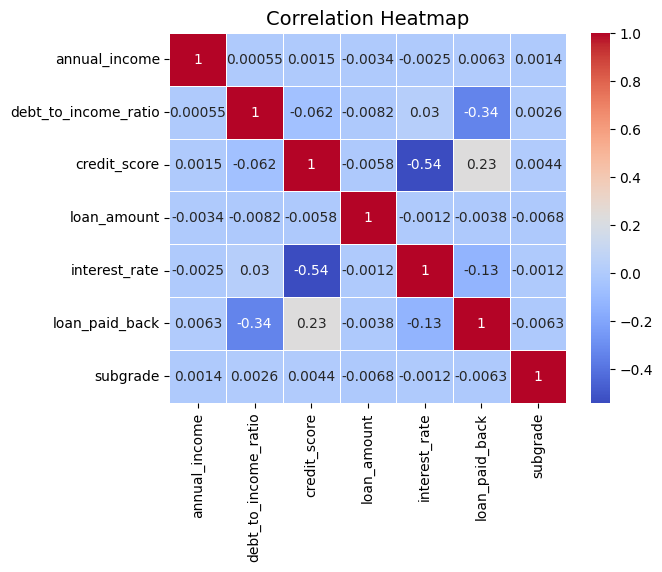

In [23]:
corr = df_train[numeric_cols].drop(columns=['id']).corr()

# Plotting
#plt.figure(figsize=figsize)
sns.heatmap(corr, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Heatmap", fontsize=14)
plt.show()

In [24]:
df_train['gender'].value_counts()

gender
Female    306175
Male      284091
Other       3728
Name: count, dtype: int64

In [25]:
features = ["annual_income", "debt_to_income_ratio", "credit_score",
       "loan_amount", "interest_rate", "grade_subgrade",
       "grade", "subgrade", 
       "gender_Female", "gender_Male", "gender_Other",
       "marital_status_Divorced", "marital_status_Married","marital_status_Single", "marital_status_Widowed",
       "education_level_Bachelor's", "education_level_High School", "education_level_Master's", "education_level_Other","education_level_PhD", 
       "employment_status_Employed",
       "employment_status_Retired", "employment_status_Self-employed", "employment_status_Student", "employment_status_Unemployed",
       "loan_purpose_Business", "loan_purpose_Car", "loan_purpose_Debt consolidation", "loan_purpose_Education",
       "loan_purpose_Home", "loan_purpose_Medical", "loan_purpose_Other","loan_purpose_Vacation"]

In [26]:
pd.get_dummies(df_train[:10], columns=['loan_purpose'], drop_first=False, dtype=int)

,id,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,gender,marital_status,education_level,employment_status,grade_subgrade,loan_paid_back,grade,subgrade,loan_purpose_Debt consolidation,loan_purpose_Education,loan_purpose_Home,loan_purpose_Other,loan_purpose_Vacation
0,0,29367.99,0.084,736,2528.42,13.67,Female,Single,High School,Self-employed,C3,1.0,C,3,0,0,0,1,0
1,1,22108.02,0.166,636,4593.10,12.92,Male,Married,Master's,Employed,D3,0.0,D,3,1,0,0,0,0
2,2,49566.20,0.097,694,17005.15,9.76,Male,Single,High School,Employed,C5,1.0,C,5,1,0,0,0,0
3,3,46858.25,0.065,533,4682.48,16.10,Female,Single,High School,Employed,F1,1.0,F,1,1,0,0,0,0
4,4,25496.70,0.053,665,12184.43,10.21,Male,Married,High School,Employed,D1,1.0,D,1,0,0,0,1,0
5,5,44940.30,0.058,653,12159.92,12.24,Male,Single,Bachelor's,Employed,D1,1.0,D,1,0,0,0,1,0
6,6,61574.16,0.042,696,16907.71,13.52,Other,Single,High School,Self-employed,C5,1.0,C,5,1,0,0,0,0
7,7,45953.31,0.100,654,10111.62,12.82,Female,Married,High School,Employed,D1,1.0,D,1,0,0,1,0,0
8,8,30592.29,0.132,713,7522.36,9.48,Male,Married,Bachelor's,Employed,C5,1.0,C,5,0,1,0,0,0
9,9,17342.45,0.121,548,9653.48,16.04,Female,Married,Bachelor's,Self-employed,F1,1.0,F,1,0,0,0,0,1


In [27]:
def prepare_data(df, traning=False):
    df = pd.get_dummies(df_train, columns=['gender', 'marital_status', 'education_level', 'employment_status', 'loan_purpose', 'grade'], drop_first=False,dtype=int).columns

    
    target= None
    if training:
        target= "loan_paid_back"
        

In [28]:
class GHotEncoder:
    def __init__(self, cat_cols):
        self.encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
        self.cat_cols = cat_cols

    def fit(self, df1, df2):
        self.merge_df = pd.concat([df1[self.cat_cols], df1[self.cat_cols]])
        self.encoder.fit(self.merge_df[self.cat_cols])
        del self.merge_df
    
    def transform(self, df):
        c1 = pd.DataFrame(self.encoder.transform(df[self.cat_cols]), columns=self.encoder.get_feature_names_out(self.cat_cols), index=df.index)
        return pd.concat([df.drop(self.cat_cols, axis=1), c1], axis=1)  

In [29]:
enc = GHotEncoder(['grade', 'gender', 'marital_status', 'education_level', 'employment_status', 'loan_purpose'])
enc.fit(df_train, df_test)

In [30]:
train_dfc = enc.transform(df_train)

In [31]:
train_dfc.head(1)

,id,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,grade_subgrade,loan_paid_back,subgrade,grade_A,...,employment_status_Student,employment_status_Unemployed,loan_purpose_Business,loan_purpose_Car,loan_purpose_Debt consolidation,loan_purpose_Education,loan_purpose_Home,loan_purpose_Medical,loan_purpose_Other,loan_purpose_Vacation
0,0,29367.99,0.084,736,2528.42,13.67,C3,1.0,3,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [32]:
features = ["annual_income", "debt_to_income_ratio", "credit_score", "loan_amount", "interest_rate",
        "subgrade",  "grade_A", "grade_B", "grade_C", "grade_D", "grade_E", "grade_F", 
            "gender_Female", "gender_Male", "gender_Other",
       "marital_status_Divorced", "marital_status_Married", "marital_status_Single", "marital_status_Widowed",
       "education_level_Bachelor's", "education_level_High School", "education_level_Master's", "education_level_Other", "education_level_PhD", "employment_status_Employed",
       "employment_status_Retired", "employment_status_Self-employed", "employment_status_Student", "employment_status_Unemployed",
       "loan_purpose_Business", "loan_purpose_Car",
       "loan_purpose_Debt consolidation", "loan_purpose_Education",
       "loan_purpose_Home", "loan_purpose_Medical", "loan_purpose_Other",
       "loan_purpose_Vacation"]
target="loan_paid_back"

In [33]:
X, y = train_dfc[features], train_dfc[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, shuffle=True, stratify=y )

In [34]:
# class DataFrameImputer:
#     """
#     Fit on train dataframe, then transform both train and test.
#     - Numeric: median
#     - Categorical: mode
#     - Boolean: mode
#     - Datetime: mode
#     """

#     def __init__(self):
#         self.fill_values = {}

#     def fit(self, df: pd.DataFrame):
#         """Learn median/mode values from TRAIN dataframe."""
#         for col in df.columns:

#             if pd.api.types.is_numeric_dtype(df[col]):
#                 self.fill_values[col] = df[col].median()

#             elif pd.api.types.is_datetime64_any_dtype(df[col]):
#                 self.fill_values[col] = df[col].mode()[0] if not df[col].mode().empty else df[col].dropna().iloc[0]

#             elif pd.api.types.is_bool_dtype(df[col]):
#                 self.fill_values[col] = df[col].mode()[0] if not df[col].mode().empty else False

#             else:  # object / category
#                 self.fill_values[col] = df[col].mode()[0] if not df[col].mode().empty else "Missing"

#         return self

#     def transform(self, df: pd.DataFrame):
#         """Apply stored values to any dataframe (train or test)."""
#         df_filled = df.copy()
#         for col, value in self.fill_values.items():
#             if col in df_filled.columns:  # only fill existing columns
#                 df_filled[col] = df_filled[col].fillna(value)
#         return df_filled

#     def fit_transform(self, df: pd.DataFrame):
#         """Fit and transform TRAIN df."""
#         return self.fit(df).transform(df)




# class ObjectToCategoryConverter:
#     """
#     Converts object columns to numeric labels (0,1,2...) using a consistent mapping.
#     - Fit learns mappings from train data.
#     - Transform applies the same mapping to test data.
#     - Unseen categories in test are mapped to -1.
#     """

#     def __init__(self):
#         self.category_maps = {}   # {column: {category: label}}
#         self.object_columns = []

#     def fit(self, df: pd.DataFrame):
#         """Identify object columns and create label mappings."""
#         self.object_columns = df.select_dtypes(include=['object']).columns.tolist()

#         for col in self.object_columns:
#             unique_vals = df[col].dropna().unique().tolist()
#             self.category_maps[col] = {val: i for i, val in enumerate(unique_vals)}

#         return self

#     def transform(self, df: pd.DataFrame) -> pd.DataFrame:
#         """Apply label encoding to object columns using fitted mappings."""
#         df_transformed = df.copy()

#         for col in self.object_columns:
#             if col in df_transformed.columns:

#                 mapping = self.category_maps[col]

#                 # Convert to numeric using mapping
#                 df_transformed[col] = df_transformed[col].map(mapping)

#                 # Handle unseen categories
#                 df_transformed[col] = df_transformed[col].fillna(-1).astype(int)

#         return df_transformed

#     def fit_transform(self, df: pd.DataFrame) -> pd.DataFrame:
#         """Fit and transform on TRAIN data."""
#         return self.fit(df).transform(df)


In [35]:
# train_fe = feature_engineer(df_train)
# test_fe  = feature_engineer(df_test)

# target = 'loan_paid_back'
# FEATURES = [c for c in train_fe.columns if c not in ['id', target, 'grade_subgrade']]

# train_X = train_fe[FEATURES].copy()
# train_y = train_fe[target].copy()
# test_X  = test_fe[FEATURES].copy()

In [36]:
# # Fill missing values
# for c in train_X.columns:
#     if train_X[c].dtype.kind in 'biufc':  # numeric
#         med = train_X[c].median()
#         train_X[c] = train_X[c].fillna(med)
#         test_X[c]  = test_X[c].fillna(med)
#     else:
#         train_X[c] = train_X[c].fillna('NA')
#         test_X[c]  = test_X[c].fillna('NA')

# # Convert object columns to categorical codes
# for c in train_X.columns:
#     if train_X[c].dtype == 'object':
#         train_X[c] = train_X[c].astype('category').cat.codes
#         test_X[c]  = test_X[c].astype('category').cat.codes

In [37]:
# imputer = DataFrameImputer()

# train_clean = imputer.fit_transform(df_train.drop(columns=['id']))
# test_clean = imputer.transform(df_test)

# converter = ObjectToCategoryConverter()

# train_clean = converter.fit_transform(train_clean)
# test_clean = converter.transform(test_clean)

In [38]:
# train_clean.head(1)

In [39]:
# X, y = train_clean.drop(columns=['loan_paid_back']), train_clean['loan_paid_back']

In [40]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, shuffle=True, stratify=y )

In [41]:
X_train[:2]

,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,subgrade,grade_A,grade_B,grade_C,grade_D,...,employment_status_Student,employment_status_Unemployed,loan_purpose_Business,loan_purpose_Car,loan_purpose_Debt consolidation,loan_purpose_Education,loan_purpose_Home,loan_purpose_Medical,loan_purpose_Other,loan_purpose_Vacation
100143,92432.16,0.067,636,14369.05,13.78,1,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
560097,28850.38,0.122,643,8471.26,14.40,5,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [42]:
X_train.columns

Index(['annual_income', 'debt_to_income_ratio', 'credit_score', 'loan_amount',
       'interest_rate', 'subgrade', 'grade_A', 'grade_B', 'grade_C', 'grade_D',
       'grade_E', 'grade_F', 'gender_Female', 'gender_Male', 'gender_Other',
       'marital_status_Divorced', 'marital_status_Married',
       'marital_status_Single', 'marital_status_Widowed',
       'education_level_Bachelor's', 'education_level_High School',
       'education_level_Master's', 'education_level_Other',
       'education_level_PhD', 'employment_status_Employed',
       'employment_status_Retired', 'employment_status_Self-employed',
       'employment_status_Student', 'employment_status_Unemployed',
       'loan_purpose_Business', 'loan_purpose_Car',
       'loan_purpose_Debt consolidation', 'loan_purpose_Education',
       'loan_purpose_Home', 'loan_purpose_Medical', 'loan_purpose_Other',
       'loan_purpose_Vacation'],
      dtype='object')

In [43]:
print(f"size of training data: {X_train.shape[0]}")
print(f"size of test data: {X_test.shape[0]}")

size of training data: 475195
size of test data: 118799


In [44]:
def disp_metrics(m, x, y):
    ypred = m.predict(x)
    acc_score = accuracy_score(y, ypred)
    print(f"acc_score: {round(acc_score, 4)}")

    cm = confusion_matrix(y, ypred)
    print("\n Confusion Matrix:")
    print(cm)

    cr = classification_report(y, ypred)
    print("\n Classification report:")
    print(cr)

    ras = roc_auc_score(y, ypred)
    print("\n roc_auc_score:")
    print(ras)

In [45]:
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)

disp_metrics(lr_model, X_train, y_train)
disp_metrics(lr_model, X_test, y_test)

acc_score: 0.7972

 Confusion Matrix:
[[  2960  92640]
 [  3719 375876]]

 Classification report:
              precision    recall  f1-score   support

         0.0       0.44      0.03      0.06     95600
         1.0       0.80      0.99      0.89    379595

    accuracy                           0.80    475195
   macro avg       0.62      0.51      0.47    475195
weighted avg       0.73      0.80      0.72    475195


 roc_auc_score:
0.5105825295744346
acc_score: 0.7971

 Confusion Matrix:
[[  759 23141]
 [  960 93939]]

 Classification report:
              precision    recall  f1-score   support

         0.0       0.44      0.03      0.06     23900
         1.0       0.80      0.99      0.89     94899

    accuracy                           0.80    118799
   macro avg       0.62      0.51      0.47    118799
weighted avg       0.73      0.80      0.72    118799


 roc_auc_score:
0.5108206520466749


In [46]:
dt_model = DecisionTreeClassifier()
dt_model.fit(X_train, y_train)

disp_metrics(dt_model, X_train, y_train)
disp_metrics(dt_model, X_test, y_test)

acc_score: 1.0

 Confusion Matrix:
[[ 95600      0]
 [     0 379595]]

 Classification report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     95600
         1.0       1.00      1.00      1.00    379595

    accuracy                           1.00    475195
   macro avg       1.00      1.00      1.00    475195
weighted avg       1.00      1.00      1.00    475195


 roc_auc_score:
1.0
acc_score: 0.8482

 Confusion Matrix:
[[15477  8423]
 [ 9605 85294]]

 Classification report:
              precision    recall  f1-score   support

         0.0       0.62      0.65      0.63     23900
         1.0       0.91      0.90      0.90     94899

    accuracy                           0.85    118799
   macro avg       0.76      0.77      0.77    118799
weighted avg       0.85      0.85      0.85    118799


 roc_auc_score:
0.77318017666966


In [47]:
dt_rfc = RandomForestClassifier()
dt_rfc.fit(X_train, y_train)

disp_metrics(dt_rfc, X_train, y_train)
disp_metrics(dt_rfc, X_test, y_test)

acc_score: 1.0

 Confusion Matrix:
[[ 95593      7]
 [     0 379595]]

 Classification report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     95600
         1.0       1.00      1.00      1.00    379595

    accuracy                           1.00    475195
   macro avg       1.00      1.00      1.00    475195
weighted avg       1.00      1.00      1.00    475195


 roc_auc_score:
0.999963389121339
acc_score: 0.9015

 Confusion Matrix:
[[14193  9707]
 [ 1990 92909]]

 Classification report:
              precision    recall  f1-score   support

         0.0       0.88      0.59      0.71     23900
         1.0       0.91      0.98      0.94     94899

    accuracy                           0.90    118799
   macro avg       0.89      0.79      0.82    118799
weighted avg       0.90      0.90      0.89    118799


 roc_auc_score:
0.7864398549508327


In [48]:
rf_params = {
    'n_estimators': [100, 200, 300],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2'],
    "bootstrap": [True, False]
}

In [49]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

rf_random_search = RandomizedSearchCV(estimator=RandomForestClassifier(random_state=42),
                                      param_distributions=rf_params, 
                                      n_iter=1, 
                                      cv=skf, 
                                      random_state=42)
rf_random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=RandomForestClassifier(random_state=42), n_iter=1,
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': [None, 10, 20, 30],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300]},
                   random_state=42)

In [50]:
# dir(rf_random_search)
rf_random_search.best_params_

{'n_estimators': 200,
 'min_samples_split': 2,
 'min_samples_leaf': 4,
 'max_features': 'log2',
 'max_depth': 10,
 'criterion': 'entropy',
 'bootstrap': False}

In [51]:
y_pred_rf_rgs = rf_random_search.predict(X_test)
print("\nRandom Forest Grid Search Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred_rf_rgs))
print("roc_auc_score:", roc_auc_score(y_test, y_pred_rf_rgs))
print("Classification Report:")
print(classification_report(y_test, y_pred_rf_rgs))


Random Forest Grid Search Performance:
Accuracy: 0.9002853559373395
roc_auc_score: 0.7657301413733808
Classification Report:
              precision    recall  f1-score   support

         0.0       0.94      0.54      0.69     23900
         1.0       0.90      0.99      0.94     94899

    accuracy                           0.90    118799
   macro avg       0.92      0.77      0.81    118799
weighted avg       0.90      0.90      0.89    118799



In [52]:
xgb.XGBClassifier()

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [53]:
# Use the XGBoost Classifier
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',  # Use 'multi:softmax' for multi-class
    use_label_encoder=False,
    # eval_metric='logloss',       # Or 'auc', 'error', etc., for classification
    eval_metric=roc_auc_score,
    random_state=42,
    n_jobs=-1
)

params = {
    'n_estimators': np.arange(100, 1001, 100),       # 100, 200, ..., 1000
    'max_depth': np.arange(3, 11),                   # 3, 4, ..., 10
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'subsample': np.arange(0.6, 1.01, 0.1),          # 0.6, 0.7, ..., 1.0
    'colsample_bytree': np.arange(0.6, 1.01, 0.1),
    'gamma': [0, 0.1, 0.2, 0.3, 0.4, 0.5],
    'reg_alpha': [0, 0.001, 0.01, 0.1, 0.5]          # L1 regularization
}

# 5 splits is a common choice
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=params,
    n_iter=100,             # Number of random combinations to try
    scoring='roc_auc',      # Metric to optimize for (e.g., AUC, F1, accuracy)
    n_jobs=-1,              # Use all available cores
    cv=cv,                  # Use the StratifiedKFold object
    verbose=2,              # Higher number prints more progress messages
    random_state=42
)

random_search.fit(X, y)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END colsample_bytree=0.7999999999999999, gamma=0, learning_rate=0.01, max_depth=10, n_estimators=900, reg_alpha=0.001, subsample=0.8999999999999999; total time= 3.0min
[CV] END colsample_bytree=0.7999999999999999, gamma=0.2, learning_rate=0.2, max_depth=6, n_estimators=500, reg_alpha=0.1, subsample=0.7999999999999999; total time=  55.2s
[CV] END colsample_bytree=0.7999999999999999, gamma=0.2, learning_rate=0.2, max_depth=6, n_estimators=500, reg_alpha=0.1, subsample=0.7999999999999999; total time=  54.9s
[CV] END colsample_bytree=0.7999999999999999, gamma=0.1, learning_rate=0.01, max_depth=10, n_estimators=800, reg_alpha=0.001, subsample=0.7999999999999999; total time= 2.7min
[CV] END colsample_bytree=0.9999999999999999, gamma=0.1, learning_rate=0.3, max_depth=7, n_estimators=800, reg_alpha=0, subsample=0.8999999999999999; total time= 1.6min
[CV] END colsample_bytree=0.9999999999999999, gamma=0.1, learning_rate=0.3, ma

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=<function roc_auc_score at 0x79f97c293ec0>,
                                           feature_types=None, g...
                   param_distributions={'colsample_bytree': array([0.6, 0.7, 0.8, 0.9, 1. ]),
                                        'gamma': [0, 0.1, 0.2, 0.3, 0.4, 0.5],
                                        'learning_rate': [0.01, 0.05, 0.1, 0.2,
                                                          0.3],
                                        'max_depth': array([ 3,  4,  5,  6,  7,  8,  9, 10]),
                                        'n_estimators': array([ 100,  200,  300,  400,  500,  600,  700,  800,  900, 1000]),
                                        'reg_alpha': [0, 0.001, 0.01, 0.1, 0.5],
                                        'subsample': array([0.6, 0.7, 0.8, 0.9, 1. ])},
                   random_state=42, scoring='roc_auc', verbose=2)

In [54]:
random_search.best_params_

{'subsample': 0.8999999999999999,
 'reg_alpha': 0.5,
 'n_estimators': 600,
 'max_depth': 3,
 'learning_rate': 0.3,
 'gamma': 0,
 'colsample_bytree': 0.7}

In [55]:
y_pred_rf_rgs = random_search.predict(X_test)
print("\nRandom Forest Grid Search Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred_rf_rgs))
print("roc_auc_score:", roc_auc_score(y_test, y_pred_rf_rgs))
print("Classification Report:")
print(classification_report(y_test, y_pred_rf_rgs))


Random Forest Grid Search Performance:
Accuracy: 0.9070867599895622
roc_auc_score: 0.7994125752104384
Classification Report:
              precision    recall  f1-score   support

         0.0       0.88      0.62      0.73     23900
         1.0       0.91      0.98      0.94     94899

    accuracy                           0.91    118799
   macro avg       0.90      0.80      0.84    118799
weighted avg       0.91      0.91      0.90    118799



In [56]:
test_dfc = enc.transform(df_test)

In [57]:
def submit_data(model, test_X):
    ypred = rf_random_search.predict(test_X[features])
    df_sub = pd.DataFrame()
    df_sub['id'] = test_X['id']
    df_sub['loan_paid_back'] = ypred
    # df = pd.DataFrame({'id': test_X['id'], 'loan_paid_back':  ypred})
    # print(df_sub.head())
    df_sub.to_csv('submission.csv', index=False)

In [58]:
submit_data(random_search, test_dfc)